# Advanced Validation Assignment  

Andrew Peabody apeab2@uis.edu

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import math

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Dataset:  Breast Cancer

In [2]:
data = pd.read_csv("breast_cancer.csv")

In [3]:
data.head()

,Unnamed: 0,id number,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,0,1000025,5,1,1,1,2,1,3,1,1,0
1,1,1002945,5,4,4,5,7,10,3,2,1,0
2,2,1015425,3,1,1,1,2,2,3,1,1,0
3,3,1016277,6,8,8,1,3,4,3,7,1,0
4,4,1017023,4,1,1,3,2,1,3,1,1,0


In [4]:
#Drop unwatned columns
data = data.drop(['Unnamed: 0', 'id number'], axis=1)

In [5]:
#Setting the feature we want to predict
y = data.pop("malignant")

In [6]:
#Create a test/train split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2, random_state=42)

### Grid Search

Optimize the RandomForestClassifier Parameters using GridSearch

In [7]:
### Grid Search
n_estimators = [i for i in xrange(100, 1001, 100)]
max_features = ['auto', 'sqrt','log2']
min_samples_split = [i for i in xrange(1, 11)]

rfc = RandomForestClassifier(n_jobs=1)
#Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(rfc,
                         dict(n_estimators=n_estimators,
                              max_features=max_features,
                              min_samples_split=min_samples_split
                              ), cv=None, n_jobs=-1)
                              

In [8]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [9]:
estimator.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
best_rfc = estimator.best_estimator_

### Accuracy



In [11]:
accuracy = accuracy_score(y_test, best_rfc.predict(X_test))
print "Accuracy: ", accuracy

Accuracy:  0.964285714286


### Precision and Recall

In [12]:
print classification_report(y_test, best_rfc.predict(X_test))

             precision    recall  f1-score   support

          0       0.97      0.98      0.97        95
          1       0.95      0.93      0.94        45

avg / total       0.96      0.96      0.96       140



In [19]:
conf = confusion_matrix(y_test, best_rfc.predict(X_test))
print conf
tp = conf[1][1]
fp = conf[0][1]
fn = conf[1][0]
print "Precision: ", tp  / float(tp + fp)
print "Recall: ", tp  / float(tp + fn)

[[93  2]
 [ 3 42]]
Precision:  0.954545454545
Recall:  0.933333333333


### AUC

In [14]:
roc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:,1])
print "AUC Score: ", roc

AUC Score:  0.99649122807


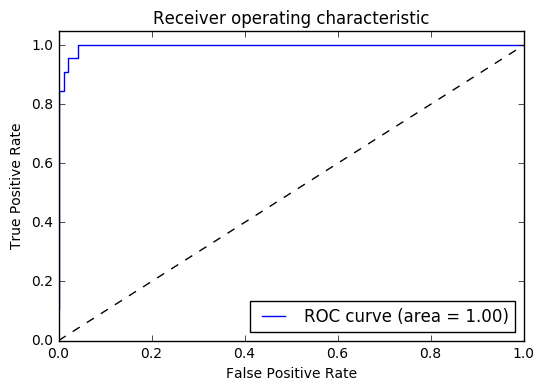

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, best_rfc.predict_proba(X_test)[:,1])
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### K-Fold Cross Validation

In [16]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(best_rfc, data, y, cv=10)

In [17]:
scores

array([ 0.91549296,  0.97142857,  0.97142857,  0.91428571,  0.98571429,
        0.98571429,  0.97142857,  0.98571429,  0.98550725,  0.98550725])

In [18]:
mean_score = scores.mean()
std_dev = scores.std()
std_error = scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.967222 +/-  0.019228
95 percent probability that if this experiment were repeated over and over the average score would be between 0.947994 and 0.986450


## AUC vs K-Fold Score

The single holdout AUC was 0.99649122807 vs the K-Fold Score of 0.967222 +/-  0.019228.  This indicates that the model is likely overly fit to the data (especially likely for small data sets), and the K-Fold score is the more accurate assessment of the models performance on an independent data set.  Another advantage of the K-Fold method is it does not require a test holdout, a major improvement for cases when the sample size is limited.  Of course for large data sets the K-Fold's repetitious nature make's its longer running time undesirable, and the large of amount of available data makes the random holdout method practical.

## Model Performance Analysis

While the model's AUC (0.99649122807) is excellent, and to some extent the Accuracy (0.964285714286) is good, that doesn't tell the whole story, especially if we are too depend on this for assistance in medical diagnosis.  For more information, we need to look at the Precision (0.954545454545) and Recall (0.933333333333).  The Previsions tells us that the model will correctly Malignancy 95% of the time, however 5% of the Malignancies will actually be false positives.  More disturbingly Recall tells us that we only caught 93% of the actual malignancies - obviously for something like cancer we would probably want to error on the side of caution and false positive (to initiate further testing and analysis) rather than false negatives (given a clean bill of health, but in fact they are Malignant).  Of course it's hard to say whether this model is "good" or "bad" in isolation.  Important considerations would include how does it compare to the current method/model, it might greatly surpass and therefore be preferable for now - however it's important for anyone using it to be aware of its limitations, and ideally I would recommend refinement that would increase the Recall, even if as a tradeoff the Precision were to suffer slightly.